<a href="https://colab.research.google.com/github/samueldmcdermott/samueldmcdermott.github.io/blob/master/SBIGalaxyClusterMass-sdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation Based Inference approach to Galaxy Cluster Mass Estimation
## 2022 AI + Science Summer School, University of Chicago
## Instructor: Camille Avestruz (UMich)

tinyurl: https://tinyurl.com/sbicltutorial


Based on ongoing analysis done by Erin Barillier (UMich), Humna Awan (UMich), Moonzarin Reza (Texas AMU), Yuanyuan Zhang (Texas AMU), and others in the Dark Energy Science Collaboration of the Rubin Observatory's [Legacy Survey of Space and Time](https://www.lsst.org/about).

Note, for another tutorial on SBI from which the SBI background in this tutorial is based, see [this link](https://astroautomata.com/blog/simulation-based-inference/).  For an overview of SBI see [here, Cranmer+2020](https://www.pnas.org/doi/10.1073/pnas.1912789117).

For a review on galaxy cluster cosmology, see [Allen+2011](https://arxiv.org/abs/1103.4829).

For a review on a wide review of observational cosmology, see [Weinberg+2012](https://arxiv.org/abs/1201.2434).

For a review on galaxy cluster simulations and astrophysics, see [Kravtsov and Borgani 2012](https://arxiv.org/abs/1205.5556)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
!pip install sbi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Below, we import relevant libraries to calculate a mass posterior using Simulation Based Inference. SBI code and more extensive demos [here](https://github.com/mackelab/sbi).

Note, `PyTorch` is used as the backend for `sbi`.

In [ ]:
import torch
from torch import zeros, ones
import sbi
import sbi.utils as utils
from sbi.utils import BoxUniform
from sbi.inference import prepare_for_sbi, simulate_for_sbi, SNPE, SNLE, SNRE
from sbi.analysis import pairplot

We will now install [colossus](https://bdiemer.bitbucket.io/colossus/), a python toolkit for calculations relevant for cosmology, the large-scale structure of the universe, and the properties of dark matter halos. The name is an acronym for COsmology, haLO and large-Scale StrUcture toolS.  We will mainly use functionality focused on dark matter halos.  (Fun fact: The main author of colossus is UofChicago alum, Benedikt Diemer, UofC Astronomy and Astrophysics PhD, 2015.)

In [ ]:
!pip install colossus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Generate idealized models of the mass distribution underlying galaxy clusters

- Create an azimuthally symmetric model of the mass distribution with an [NFW profile](https://en.wikipedia.org/wiki/Navarro%E2%80%93Frenk%E2%80%93White_profile)
- Visualize the mass distribution of halos (in which luminous galaxies and galaxy clusters sit), with the [halo mass function](https://en.wikipedia.org/wiki/Halo_mass_function)
- Look at the theoretical relationship between the parameters of the NFW profile, the concentration-mass relation. 
- Create "simulated data" for the SBI.

The distribution of matter (both dark and light) depends on cosmology.  This generally means a model that can predict the contents and history of our universe.  We have a "standard model" of cosmology, which can be describe with a set of parameters that can be constrained with data.  To use colossus objects, we will first define a cosmology based on [Planck 2018 data](https://arxiv.org/abs/1807.06205) from the Cosmic Microwave Background (see CMB map below).
<img src=https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2013/03/planck_cmb/12583930-4-eng-GB/Planck_CMB_pillars.jpg width="500">

In [ ]:
# First, define a cosmology
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')

### Halo mass function

The number of objects as a function of their mass and time changes with cosmology.  We want to be able to measure this as well as we can.  Below, we illustrate the halo mass function for two different cosmologies from [Vikhlinin+09](https://ui.adsabs.harvard.edu/abs/2009ApJ...692.1060V/abstract).  Here, the cosmological parameter describing the energy density of matter stays teh same, and the parameter describing the energy density of dark energy (responsible for the accelerated expansion of the universe) changes.  

**Note and fun exercise for when you get home**, you can use colossus to create your own mass functions for different cosmologies.  

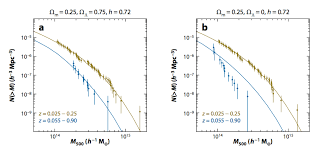

In [ ]:
# Exercise for home:  Look over the colossus documentation, and plot a halo mass function for different cosmological models

### Space to play here ###

## Dark matter halos

Most of the mass in our universe is in the form of non-luminous [dark matter](https://en.wikipedia.org/wiki/Dark_matter), a weakly interacting substance that we have largely inferred from dynamics.  Dark matter halos are gravitationally collapsed objects, in which luminous galaxies and galaxy clusters sit (see cartoon of Milky Way galaxy in its dark matter halo below).  Their abundance and evolution traces cosmology  (as seen above).  We can model the mass distribution of a single dark matter halo with an NFW profile, with two physical parameters: mass enclosed and concentration (peakiness). 

<img src=https://stsci-opo.org/STScI-01EVT45FFZGVBCBG2YS9B7P874.jpg width="500">
<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Comparison_of_NFW_and_Einasto_profiles.svg/1024px-Comparison_of_NFW_and_Einasto_profiles.svg.png width="500">

In [ ]:
# Create an NFW profile
from colossus.halo import profile_nfw

def simulate_nfw(log10mass, concentration) :
  '''
  Simulate an NFW profile at the present day (z=0), with mass and concentration 
  defined with respect to the virial radius 
  '''
  return profile_nfw.NFWProfile(M = 10**log10mass, c = concentration, z = 0.0, mdef = 'vir')

Below, we plot example profiles at redshift 0 (present day) with different masses and concentrations, and normalize by the mean density of the universe today.



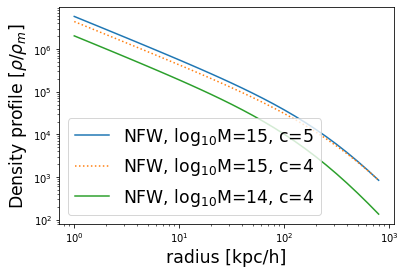

In [ ]:
# Plot an example profile

radius = 10**np.arange(0,3,0.1)
rho_m = cosmo.rho_m(0)
rho_nfwm14c4 = simulate_nfw(log10mass=14, concentration=4).density(radius)
rho_nfwm15c4 = simulate_nfw(log10mass=15, concentration=4).density(radius)
rho_nfwm15c5 = simulate_nfw(log10mass=15, concentration=5).density(radius)


plt.figure()
plt.loglog()
plt.xlabel('radius [kpc/h]', fontsize='xx-large')
plt.ylabel('Density profile [$\\rho/\\rho_m$]', fontsize='xx-large')
plt.plot(radius, rho_nfwm15c5 / rho_m, '-', label = 'NFW, log$_{10}$M=15, c=5')
plt.plot(radius, rho_nfwm15c4 / rho_m, ':', label = 'NFW, log$_{10}$M=15, c=4')
plt.plot(radius, rho_nfwm14c4 / rho_m, '-', label = 'NFW, log$_{10}$M=14, c=4')
plt.legend(fontsize='xx-large');

Note, we have just plotted a theoretical model for the mass distribution of massive halos corresponding to the hosts of galaxy clusters at the present day.  But, galaxy clusters are *not* spherical cows, and we cannot directly measure their mass distribution.  What really happens, is that we have to *infer* their masses based on some observable.  While we have plotted predictions of the density profile, one way to observe and infer the mass of these objects is through gravitational lensing.  

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Shapenoise.svg/800px-Shapenoise.svg.png size="500">

We measure the distortions of background galaxies due to the mass of a galaxy cluster that bends light, acting as a lens. You may have seen some of the most recent images of a galaxy cluster from JWST:

<img src=http://www.nasa.gov/sites/default/files/thumbnails/image/main_image_deep_field_smacs0723-5mb.jpg size="500">

**Concentration of an NFW profile** Let us now look at a theoretical prediction for how concentration and mass are related to one another on average.  We expect these to be related to one another because more massive objects take longer to form, as less massive objects must merge into one another to gather more and more mass.  This is known as hierarchical structure formation.  Earlier in the universe, there was the same amount of mass, but a smaller volume (we are expanding at an accelerated rate!); the universe was denser at earlier times leading to earlier formed objects having higher concentrations.  We expect an (on average) monotonic relationship between concentration and mass.

In [ ]:
# Define the theoretical concentration mass relationship from colossus
from colossus.halo import concentration

def get_concentration(log10mass) :
  '''
  Return the concentration for a halo of a given mass assuming a model of child18
  at the present day (redshift 0.0), defined with respect to the virial radius. 
  '''

  return concentration.concentration(10**log10mass, 'vir', 0.0, model = 'child18')

Now, we plot the concentration mass relationship across the range of galaxy cluster masses (galaxy groups are roughly 1e13 M$_\odot$, and the most massive clusters are roughly 1e15 M$_\odot$).  We have assumed the theoretical relationship measured from numerical simulations in [Child+2019](https://arxiv.org/pdf/1804.10199.pdf).  But, this is an *on-average* relationship.  We assume some scatter about the relation for slightly more "realistic" objects.

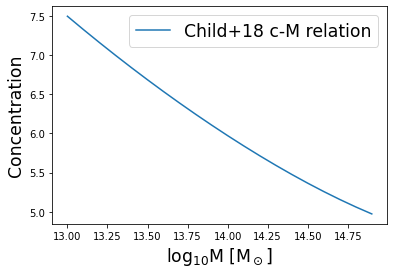

In [ ]:
# Plot concentration mass relationship from Child+2018

cluster_log10masses = np.arange(13,15,0.1)

plt.plot(cluster_log10masses, get_concentration(cluster_log10masses),label='Child+18 c-M relation')
plt.xlabel('log$_{10}$M [M$_\odot$]', fontsize='xx-large')
plt.ylabel('Concentration', fontsize='xx-large')
plt.legend(fontsize='xx-large')

Now, we define a sample to make "simulations" with.  We define 10000 masses in the range of 1e13$\lesssim M/M_\odot\lesssim$1e15, and assign a concentration following the Child+19 model with some noise.

In [ ]:
# Define a mass sample with some noise, and concentration sample that scatters
# about the theoretical prediction

log10mass_sample = np.random.uniform(13,15,size=10000)
non_noisy_concentration_sample = get_concentration(log10mass_sample)
noisy_concentration = np.random.normal(non_noisy_concentration_sample,0.2,10000)

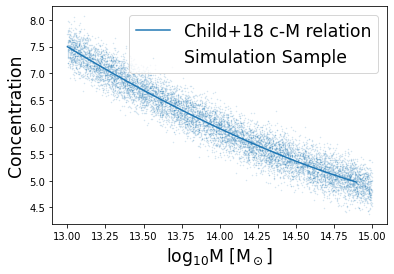

In [ ]:
# Plot the samples and compare with the original theory relation
plt.scatter(log10mass_sample, noisy_concentration,s=0.2,alpha=0.2, label='Simulation Sample')
plt.plot(cluster_log10masses, get_concentration(cluster_log10masses),label='Child+18 c-M relation')
plt.xlabel('log$_{10}$M [M$_\odot$]', fontsize='xx-large')
plt.ylabel('Concentration', fontsize='xx-large')
plt.legend(fontsize='xx-large')

Now, let's create the corresponding NFW profiles for our sample to train our model.

In [ ]:
# generate the simulated NFW profiles
simulated_nfw_profiles = np.array([simulate_nfw(log10mass=log10mass, concentration=concentration).density(radius) \
                            for log10mass, concentration in zip(log10mass_sample, noisy_concentration)])

Now we train the density estimator.  

**Note on simple interface**: the SBI tutorial shows a "simple interface" if you have a method that can act as a simulator, where you would simply skip pre-simulating data, and can infer a posterior with the simulator method, and a prior, e.g.

`parameter_posterior = infer(simulator, prior, method='SNPE', num_simulations=100)`

Instead, we will: 
- use the pre-simulated NFW profiles (line above), 
- train a density estimator,
- obtain our posterior for a new "observation" of a density profile to see how well we can measure its mass and concentration.

### Use pre-simulated NFW profiles for model

The task at hand is to perform inference on the parameters of the density profile of a dark matter halo ($\theta=[$mass, concentration$]$) given observations of the dark matter profile, $x_i=\rho_i(r)$:

$$
P(M_{vir}, c_{vir}|\rho_i(r))
$$

Instead of relying on a likelihood function, $P(\rho_i(r)|M_{vir}, c_{vir})$, we simulate various density profiles given a mass and concentration pair.  This is one of the inherent differences between the SBI approach, and a standard MCMC approach (in cosmology/astrophysics) for parameter estimation, which relies on constructing a likelihood.

![](https://drive.google.com/uc?id=1KrtsVf_5C8n5enKsF8JS_1A32PYkfJdM)


Note, we use a prediction of the concentration-mass relation with some noise and simulate enough (10,000 profiles) so we can measure the frequency of examples that reproduce the data. (See more info on Approximate Bayesian Computation [here](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation)).

Given a number of simulations, we then fit a function:

$$
P(M_{vir}, c_{vir}|\rho_i(r))
$$

such that $\sum_i logP(M_{vir}, c_{vir}|\rho_i(r))$ is maximized over the data.

In [ ]:
# Define our data in terms of parameters, theta, and data
theta_np = np.array([log10mass_sample,noisy_concentration]).T
x_np = simulated_nfw_profiles

Check that our parameters consist of 10,000 simulations of 2 parameter sets and that our data is 10,000 simulations of 30 radial bins.

In [ ]:
print(np.shape(theta_np), np.shape(x_np))

(10000, 2) (10000, 30)


With Simulation Based Inference, we bypass a likelihood based MCMC process.  Instead, of being given the likelihood of the NFW profile, we have only drawn samples from various NFW profiles whose mass and concentration are close to what we might expect from theory.  Those are our "simulation".  Alternatively, we might have written a "simulator" (see note on "Simple Interface" above).

Below, we include the final required piece: a prior distribution that allows to sample sets of mass and concentration.

In [ ]:
# Uniform prior from -20 to 20 (which encompasses possible log10 masses and concentration values)
num_priors = np.shape(theta_np)[1]
prior = BoxUniform(-ones(num_priors)*20, ones(num_priors)*20)

Here, we make sure our data type is compatible with the `sbi` backend.

In [ ]:
# turn into tensors
theta = torch.as_tensor(theta_np, dtype=torch.float32)
x = torch.as_tensor(x_np, dtype=torch.float32)

### Train a density estimator

There are several inference algorithms available through the `sbi` package.  We will use the option Sequential Neural Posterior Estimation (SNPE) [paper link](https://arxiv.org/abs/1905.07488).  

This step uses neural networks with some imposed smoothness regularization on the parameters to avoid overfitting is to ensure that $P(M_{vir}, c_{vir}|\rho_i(r))$ is normalized.  You can then, for example, sample a Gaussian and go forward through model to sample the learned distribution. Invert the model and go backward from a sample to the compute the likelihood.

Below, we use SNPE to fit the joint surface of the mass, concentration, and density profile.

In [ ]:
# Create inference object: choose method and estimator
inferer = SNPE(prior, density_estimator="mdn", device="cpu")  # SNLE, SNRE are other options
# Append training data
inferer = inferer.append_simulations(theta, x)

In [ ]:
# Train  (note: Lots of training settings.)
density_estimator = inferer.train(num_atoms=4, training_batch_size=50, 
                                  learning_rate=0.0005, validation_fraction=0.1, 
                                  stop_after_epochs=20, max_num_epochs=500, 
                                  clip_max_norm=5.0, calibration_kernel=None, 
                                  exclude_invalid_x=True, resume_training=False, 
                                  discard_prior_samples=False, use_combined_loss=False, 
                                  show_train_summary=False, dataloader_kwargs=None)  


 Neural network successfully converged after 96 epochs.

### Obtain a posterior and visualize



In [ ]:
# Build posterior using trained density estimator
posterior = inferer.build_posterior(density_estimator)  # Posterior sampling settings.

Let's create a new observation of a density profile that follows the same NFW.  Let's see how well we can constrain the mass and concentration of a cluster that sits somewhere in the middle of the samples, e.g. $log_{10}M/M_\odot=14$ and $c=6$.

In [ ]:
def create_observation_nfw(log10M_obs_true, concentration_obs_true) :
  '''
  Observation of an NFW profile for some log10 M and concentration.

  Returns the parameters (input), and the observations (radial profile) as tensors
  '''
  theta_truth_np = np.array([log10M_obs_true, concentration_obs_true])
  x_truth_np = simulate_nfw(log10mass=log10M_obs_true, concentration=concentration_obs_true).density(radius)

  print(np.shape(theta_truth_np))
  print(np.shape(x_truth_np))

  # turn into tensors
  theta_o = torch.as_tensor(theta_truth_np, dtype=torch.float32) 
  x_o = torch.as_tensor(x_truth_np, dtype=torch.float32)

  return theta_o, x_o

Now, let's visualize the posterior mass and concentration.  We'll use `pygtc` [GitHub](https://github.com/SebastianBocquet/pygtc) [paper](https://joss.theoj.org/papers/10.21105/joss.00046) (I had some issues with dependencies and other visualization tools, but many other exist).  

**Fun fact**:  The authors of `pygtc`, Sebastian Bocquet and Faustin Carter, developed the code while postdocs at Argonne, with joint appointments at UChicago.

In [ ]:
!pip install pygtc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pygtc

(2,)
(30,)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

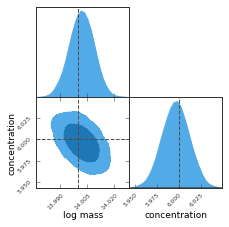

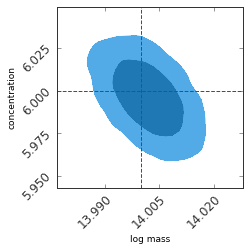

In [ ]:
# Create an observation - first for logM=14, c=6, which is roughly on the Child+ predictions
theta_o, x_o = create_observation_nfw(14, 6) 

# Obtain samples of the posterior given the observation
samples = posterior.sample((10000,), x=x_o)

# Redefine priors and truths
priors2d = ((-20,20),(20,20))
truths2d = (theta_o.numpy()[0], theta_o.numpy()[1])

# The 2d panel and the 1d histograms
GTC = pygtc.plotGTC(chains=[samples.numpy()],
                    paramNames=['log mass', 'concentration'],
                    truths=truths2d,
                    priors=priors2d,
                    figureSize='MNRAS_column')

GTC = pygtc.plotGTC(chains=[samples.numpy()],
                    paramNames=['log mass', 'concentration'],
                    truths=truths2d,
                    priors=priors2d,
                    figureSize='MNRAS_column',
                    do1dPlots=False, customTickFont={'family':'Arial', 'size':12})

Now, let's see what happens when we provide an observation whose mass and concentration are quite far from the theoretical prediction.

(2,)
(30,)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

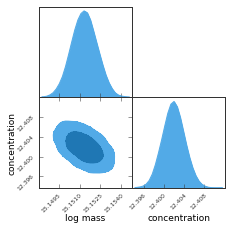

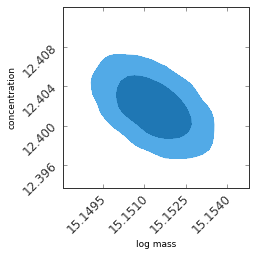

In [ ]:
# Now, we create an observation - far from the Child+ predictions, logM=15, c=10
theta_o, x_o = create_observation_nfw(15, 10) 

# Obtain samples of the posterior given the observation
samples = posterior.sample((10000,), x=x_o)

# Redefine priors and truths
priors2d = ((-20,20),(20,20))
truths2d = (theta_o.numpy()[0], theta_o.numpy()[1])

# The 2d panel and the 1d histograms
GTC = pygtc.plotGTC(chains=[samples.numpy()],
                    paramNames=['log mass', 'concentration'],
                    truths=truths2d,
                    priors=priors2d,
                    figureSize='MNRAS_column')

GTC = pygtc.plotGTC(chains=[samples.numpy()],
                    paramNames=['log mass', 'concentration'],
                    truths=truths2d,
                    priors=priors2d,
                    figureSize='MNRAS_column',
                    do1dPlots=False, customTickFont={'family':'Arial', 'size':12})


**Discussion**: 
- Where are the posteriors compared with the known truth for this observation?  Why might this happen?
- We have thus far dealt with idealized profiles - assumptions of azimuthal symmetry and that observations will follow near the theoretical predictions.  Why might those assumptions break down?


**Prompt for your own experimentation** (if there is time, or to take home with you):  
- See what happens to the shape of the posterior as you increase the noise for the mass sample and noisy concentration (e.g. so your concentration-mass data points for the simulation cover more of the space - you can simply increase the standard deviation when we call `np.random.normal`.
- Try changing the mass distribution so you either have more points at low mass or more points at high mass (we used a uniform sampling across masses).
- Try changing the prior.

In [ ]:
### Start your experiments here!  ###